# Neural Networks for Sequence Data

In this notebook I want to demonstrate how easy it is to train a Neural Network (NN) on DNA data, 
make predictions for Transcription Factor Binding Sites (TFBS) and extract the learned motif with a simple gradient-based method.

## Load Necessary Libraries

In [1]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Flatten

from keras.models import Sequential

import numpy as np
from sklearn.metrics import roc_curve, auc, average_precision_score

from helper import IOHelper, SequenceHelper

Using Theano backend.


## Load the sequence data

There are two example files available `data/ctcf.fa.gz` and `data/pu1.fa.gz`

In [2]:
input_real = IOHelper.get_fastas_from_file("data/pu1.fa.gz", uppercase=True)
sequence_length = len(input_real.sequence[0])
X_real = SequenceHelper.do_one_hot_encoding(input_real.sequence, sequence_length,
                                            SequenceHelper.parse_alpha_to_seq)

The negative data is generated by shuffling the positive data

In [3]:
def do_dinucleotide_shuffling(X, size=1):
    x_shuffled = np.repeat(X, size, 0)

    for x in range(0, x_shuffled.shape[0]):
        random_index = np.arange(0, int(X.shape[1]/2))
        np.random.shuffle(random_index)
        for y in range(0, int(X.shape[1]/2)):
            x_shuffled[x,y*2, ] = X[int(x%X.shape[0]),random_index[y]*2]
            x_shuffled[x,(y*2)+1, ] = X[int(x%X.shape[0]),(random_index[y]*2)+1]

    return x_shuffled

seq_shuffled = do_dinucleotide_shuffling(np.array([[[e] for e in list(x)] for x in input_real.sequence]), size=1)
seq_shuffled = np.array(["".join(seq_shuffled[x, :, 0]) for x in range(seq_shuffled.shape[0])])
X_shuffled = SequenceHelper.do_one_hot_encoding(seq_shuffled, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

## Create the Neurol Network Architecture

We start with a fairly simple NN architeture of a single convolutional layer followed by a max-pooling layer
and then a single dense layer.

In [4]:

model = Sequential()
model.add(Conv2D(16, (12, 4), padding='valid', input_shape=(100, 4, 1),
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(15,1), padding='valid'))

model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error', optimizer='sgd')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 89, 1, 16)         784       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2592      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 3,409.0
Trainable params: 3,409.0
Non-trainable params: 0.0
_________________________________________________________________


## Create a test and a training subset

To have a reasonable estimate of the training, the data is split into a training (80%) and a test (20%) set.

In [5]:
shuffling = np.arange(X_real.shape[0] + X_shuffled.shape[0])
np.random.shuffle(shuffling)

X = np.concatenate((X_real, X_shuffled))[shuffling, :, :]
X = np.nan_to_num(X)
Y = np.concatenate((np.ones(X_real.shape[0]), np.zeros(X_shuffled.shape[0])))[shuffling]


X_train = X[0:int(X.shape[0]*0.8), :, :]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
Y_train = Y[0:int(X.shape[0]*0.8)]
X_test = X[int(X.shape[0]*0.8):X.shape[0], :, :]
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))
Y_test = Y[int(X.shape[0]*0.8):X.shape[0]]

In [6]:
print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(45883, 100, 4, 1)
(11471, 100, 4, 1)


## Fit the Model

The NN is trained with the training set for 25 epochs. The test set is used to assess the actual training success after each epoch.

This step can take a few minutes.

In [7]:
model.fit(X_train_reshaped, Y_train,
          batch_size=10, epochs=25,
          validation_data=(X_test_reshaped, Y_test))


Train on 45883 samples, validate on 11471 samples
Epoch 1/25
45883/45883 [==============================] - 13s - loss: 0.2430 - val_loss: 0.2177
Epoch 2/25
45883/45883 [==============================] - 13s - loss: 0.1498 - val_loss: 0.1188
Epoch 3/25
45883/45883 [==============================] - 13s - loss: 0.0951 - val_loss: 0.0833
Epoch 4/25
45883/45883 [==============================] - 13s - loss: 0.0777 - val_loss: 0.0698
Epoch 5/25
45883/45883 [==============================] - 13s - loss: 0.0671 - val_loss: 0.0619
Epoch 6/25
45883/45883 [==============================] - 13s - loss: 0.0580 - val_loss: 0.0545
Epoch 7/25
45883/45883 [==============================] - 13s - loss: 0.0521 - val_loss: 0.0496
Epoch 8/25
45883/45883 [==============================] - 13s - loss: 0.0486 - val_loss: 0.0471
Epoch 9/25
45883/45883 [==============================] - 13s - loss: 0.0461 - val_loss: 0.0456
Epoch 10/25
45883/45883 [==============================] - 13s - loss: 0.0442 - val_lo

## Evaluating the Model

After the NN was trained the test set is used to calculate the [AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [AUPRC](https://en.wikipedia.org/wiki/Precision_and_recall) (different combinations of the number of true and false predictions).

In [8]:
pred = model.predict(X_test_reshaped, batch_size=32).flatten()
fpr, tpr, thresholds = roc_curve(Y_test, pred)
print("AUC", auc(fpr, tpr))
print("AUPRC", average_precision_score(Y_test, pred))

AUC 0.986270096899
AUPRC 0.98473389649


In [9]:
pred

array([ 0.99992126,  0.97798598,  0.03157011, ...,  0.00934646,
        0.01430372,  0.98940289], dtype=float32)

## Make a motif plot:

In [10]:
score_sequences = range(0, 5)

X_For_Scoring = X_real.reshape((X_real.shape[0], X_real.shape[1], X_real.shape[2], 1))[score_sequences, :]
Pred_For_Scoring = model.predict(X_For_Scoring, batch_size=32).flatten()
tmp = np.repeat(X_For_Scoring, 100, axis=0)

#### Calculate Gradient

In [11]:
a = np.ones((100, 100), int)
np.fill_diagonal(a, 0)
b = np.repeat(a.reshape((1,100,100)), X_For_Scoring.shape[0], axis=0)
c = np.concatenate(b, axis=0)
d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 100, 1, 1)), 4, axis=2))

In [12]:
new_pred = model.predict(d, batch_size=32).flatten()
scores = np.reshape((np.repeat(Pred_For_Scoring, 100) - new_pred), (len(score_sequences),100))
# scores = np.reshape((1-new_pred)/(1-np.repeat(Pred_For_Scoring, 100))-1, (len(score_sequences),100))

#### Make the Actual Plot

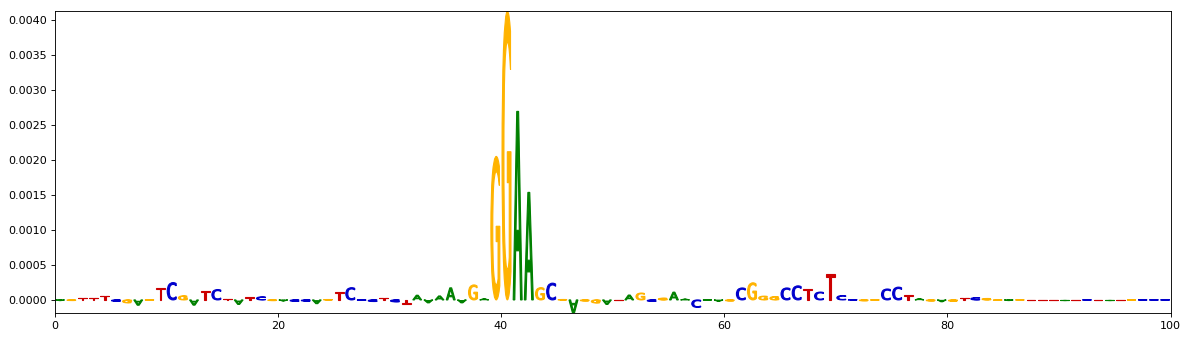

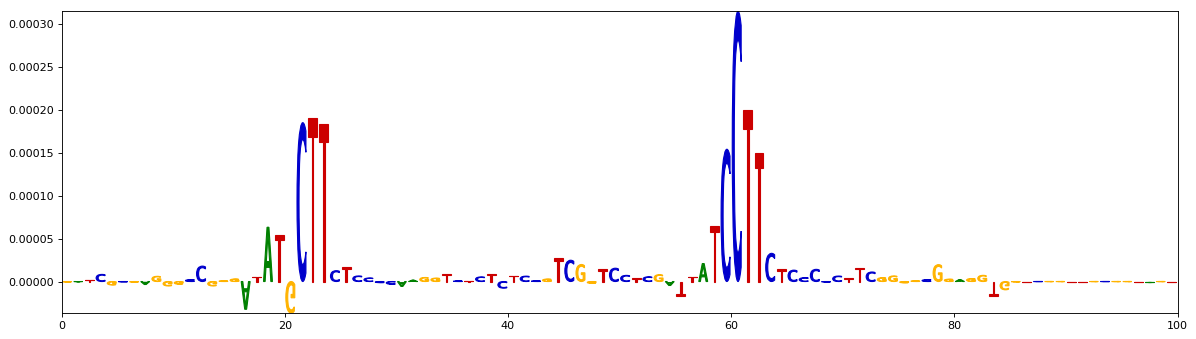

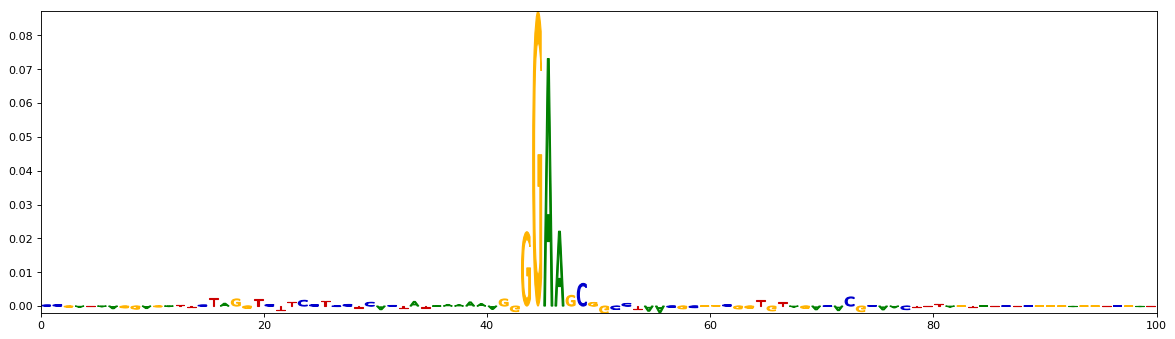

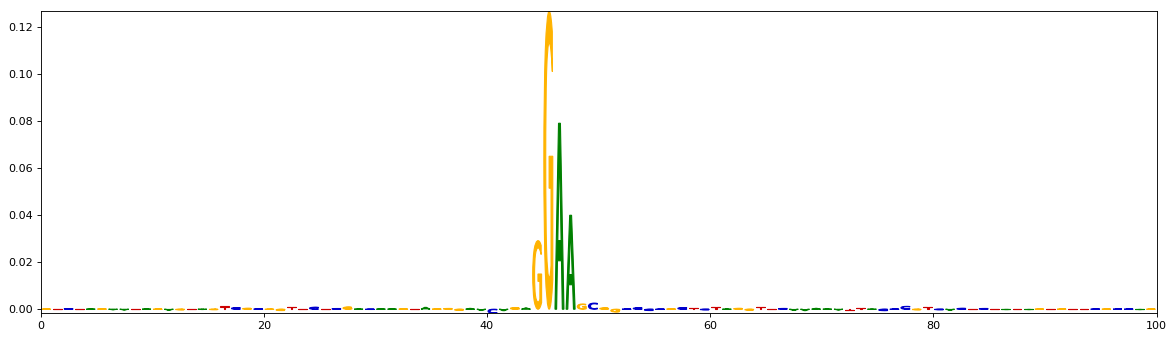

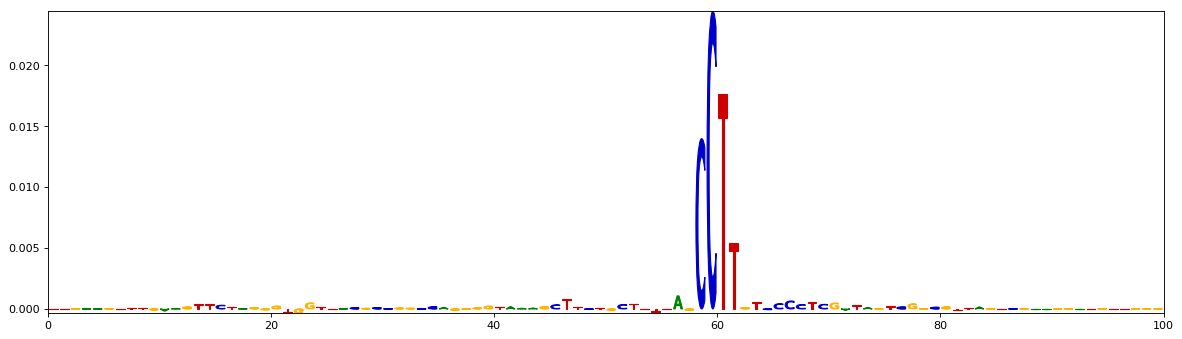

In [13]:
%matplotlib inline

import motif_plotter
import matplotlib.pyplot as plt

for plot_index in range(0,len(score_sequences)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, X_For_Scoring[plot_index].reshape((100, 4)),
                                                np.arcsinh(scores[plot_index]).reshape(100,1))
    plt.show()
